In [259]:
# Structure
# ---------
# 1. Get information for this prediction
#    - Parse teams
#    - Get information on both teams
#    - Combine information into one dataset - set aside as observations for test prediction
# 2. Get information for all historical matches
#    - Iterate through match pairings, building an observation for each pair, with the response as FTR
# 3. Train a classifier
#    - Minimize predictive error on historic matches
# 4. Make test prediction against "Pr(Home win)"
#    - Log prediction accuracy
# 5. Make dummy predictions against "Pr(Home win)" (Stratified, random, home-only etc.)

### 1. Load Libraries

In [656]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
from sklearn import preprocessing
from matplotlib import pyplot as plt
%matplotlib inline

### 2. Import dataset

In [569]:
Dataset['EPL 16/17 raw'] = pd.read_csv('http://www.football-data.co.uk/mmz4281/1617/E0.csv', parse_dates=['Date'],
                             date_parser=(lambda date_str: pd.datetools.to_datetime(date_str, errors='coerce', dayfirst=True)))
Dataset['EPL 15/16 raw'] = pd.read_csv('http://www.football-data.co.uk/mmz4281/1516/E0.csv', parse_dates=['Date'],
                             date_parser=(lambda date_str: pd.datetools.to_datetime(date_str, errors='coerce', dayfirst=True)))

In [927]:
Dataset['EPL 15/16 raw'].head(5)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,2015-08-08,Bournemouth,Aston Villa,0,1,A,0,0,D,...,1.79,26,-0.5,1.98,1.93,1.99,1.92,1.82,3.88,4.70
1,E0,2015-08-08,Chelsea,Swansea,2,2,D,2,1,H,...,1.99,27,-1.5,2.24,2.16,1.80,1.73,1.37,5.04,10.88
2,E0,2015-08-08,Everton,Watford,2,2,D,0,1,A,...,1.96,26,-1.0,2.28,2.18,1.76,1.71,1.75,3.76,5.44
3,E0,2015-08-08,Leicester,Sunderland,4,2,H,3,0,H,...,1.67,26,-0.5,2.00,1.95,1.96,1.90,1.79,3.74,5.10
4,E0,2015-08-08,Man United,Tottenham,1,0,H,1,0,H,...,2.01,26,-1.0,2.20,2.09,1.82,1.78,1.64,4.07,6.04


### 3. Feature descriptions
`Div` = League Division <br>
`Date` = Match Date (dd/mm/yy)<br>
`HomeTeam` = Home Team<br>
`AwayTeam` = Away Team<br>
`FTHG` = Full Time Home Team Goals<br>
`FTAG` = Full Time Away Team Goals<br>
`FTR` = Full Time Result (H=Home Win, D=Draw, A=Away Win)<br>
`HTHG` = Half Time Home Team Goals<br>
`HTAG` = Half Time Away Team Goals<br>
`HTR` = Half Time Result (H=Home Win, D=Draw, A=Away Win)<br>

Match Statistics (where available)<br>
`Attendance` = Crowd Attendance<br>
`Referee` = Match Referee<br>
`HS` = Home Team Shots<br>
`AS` = Away Team Shots<br>
`HST` = Home Team Shots on Target<br>
`AST` = Away Team Shots on Target<br>
`HHW` = Home Team Hit Woodwork<br>
`AHW` = Away Team Hit Woodwork<br>
`HC` = Home Team Corners<br>
`AC` = Away Team Corners<br>
`HF` = Home Team Fouls Committed<br>
`AF` = Away Team Fouls Committed<br>
`HO` = Home Team Offsides<br>
`AO` = Away Team Offsides<br>
`HY` = Home Team Yellow Cards<br>
`AY` = Away Team Yellow Cards<br>
`HR` = Home Team Red Cards<br>
`AR` = Away Team Red Cards<br>
`HBP` = Home Team Bookings Points (10 = yellow, 25 = red)<br>
`ABP` = Away Team Bookings Points (10 = yellow, 25 = red)<br>

Key to 1X2 (match) betting odds data:<br>
`B365H` = Bet365 home win odds<br>
`B365D` = Bet365 draw odds<br>
`B365A` = Bet365 away win odds<br>
`BSH` = Blue Square home win odds<br>
`BSD` = Blue Square draw odds<br>
`BSA` = Blue Square away win odds<br>
`BWH` = Bet&Win home win odds<br>
`BWD` = Bet&Win draw odds<br>
`BWA` = Bet&Win away win odds<br>
`GBH` = Gamebookers home win odds<br>
`GBD` = Gamebookers draw odds<br>
`GBA` = Gamebookers away win odds<br>
`IWH` = Interwetten home win odds<br>
`IWD` = Interwetten draw odds<br>
`IWA` = Interwetten away win odds<br>
`LBH` = Ladbrokes home win odds<br>
`LBD` = Ladbrokes draw odds<br>
`LBA` = Ladbrokes away win odds<br>
`PSH` = Pinnacle home win odds<br>
`PSD` = Pinnacle draw odds<br>
`PSA` = Pinnacle away win odds<br>
`SOH` = Sporting Odds home win odds<br>
`SOD` = Sporting Odds draw odds<br>
`SOA` = Sporting Odds away win odds<br>
`SBH` = Sportingbet home win odds<br>
`SBD` = Sportingbet draw odds<br>
`SBA` = Sportingbet away win odds<br>
`SJH` = Stan James home win odds<br>
`SJD` = Stan James draw odds<br>
`SJA` = Stan James away win odds<br>
`SYH` = Stanleybet home win odds<br>
`SYD` = Stanleybet draw odds<br>
`SYA` = Stanleybet away win odds<br>
`VCH` = VC Bet home win odds<br>
`VCD` = VC Bet draw odds<br>
`VCA` = VC Bet away win odds<br>
`WHH` = William Hill home win odds<br>
`WHD` = William Hill draw odds<br>
`WHA` = William Hill away win odds<br>

`Bb1X2` = Number of BetBrain bookmakers used to calculate match odds averages and maximums<br>
`BbMxH` = Betbrain maximum home win odds<br>
`BbAvH` = Betbrain average home win odds<br>
`BbMxD` = Betbrain maximum draw odds<br>
`BbAvD` = Betbrain average draw win odds<br>
`BbMxA` = Betbrain maximum away win odds<br>
`BbAvA` = Betbrain average away win odds<br>

### Warm-up: Show that the home team wins more frequently than the away team

In [289]:
Dataset['EPL raw'].FTR.value_counts()

H    62
A    42
D    36
Name: FTR, dtype: int64

### Convert pair of teams to match information

In [309]:
def get_max_win_streak(data, team):
    # Gets the maximum win streak of the team handed to it (includes both home and away games)
    home_matches = data.loc[data.HomeTeam==team, :]
    away_matches = data.loc[data.AwayTeam==team, :]
    matches = pd.concat([home_matches, away_matches], axis=0)
    matches.sort_values(by='Date', ascending=False, inplace=True)
    wins = pd.concat([pd.Series(home_matches.FTR=='H', index=home_matches.index), pd.Series(away_matches.FTR=='A',
                                                                                           index=away_matches.index)], axis=0)
    matches['Won'] = wins
    streak = 0
    max_streak = 0
    for result in matches['Won']: # Iterates through matches by recency
        if result:
            streak += 1
            if streak > max_streak:
                max_streak = streak
        else:
            streak = 0
    return max_streak

In [454]:
def get_result_history(data, team):
    # Returns series of team's match history, with {Win, loss, draw} -> {1, -1, 0}
    home_matches = data.loc[data.HomeTeam==team, :]
    away_matches = data.loc[data.AwayTeam==team, :]
    matches = pd.concat([home_matches, away_matches], axis=0)
    matches.sort_values(by='Date', ascending=False, inplace=True)
    wins = pd.concat([pd.Series(home_matches.FTR=='H', index=home_matches.index), pd.Series(away_matches.FTR=='A',
                                                                                           index=away_matches.index)], axis=0)
    losses = pd.concat([pd.Series(home_matches.FTR=='A', index=home_matches.index), pd.Series(away_matches.FTR=='H',
                                                                                           index=away_matches.index)], axis=0)
    results = wins.astype(int) - losses.astype(int)
    return results

In [457]:
def get_current_streak(data, team):
    # Gets the current win/loss streak of the team handed to it (includes both home and away games)
    # Get matches, sort matches by recency, take most recent result type and iterate backwards through matches until it changes
    history = get_result_history(data, team)
    initial_result = history.values[0]
    streak = 0
    for result in history: # Iterates through matches by recency
        if result == initial_result:
            streak += result
        else:
            return streak
            break
    return streak

In [317]:
def get_team(data, team, home=True):
    # Extracts information on a team-by-team basis
    # Features that need adding:
    #    SD of shots, corners, fouls etc.
    #    Red cards, yellow cards, fouls, offsides, booking points
    #    Half time results
    #    everything scaled by number of matches played
    team_info = pd.Series(name=team)
    home_matches = data.loc[data.HomeTeam==team, :]
    away_matches = data.loc[data.AwayTeam==team, :]
    team_info['played_home'] = len(home_matches.FTR)
    team_info['played_away'] = len(away_matches.FTR)
    team_info['played'] = team_info['played_home'] + team_info['played_away']
    team_info['wins_home'] = home_matches.FTR.loc[home_matches.FTR=='H'].count()
    team_info['wins_away'] = away_matches.FTR.loc[away_matches.FTR=='A'].count()
    team_info['wins'] = team_info['wins_home'] + team_info['wins_away']
    team_info['draws_home'] = home_matches.FTR.loc[home_matches.FTR=='D'].count()
    team_info['draws_away'] = away_matches.FTR.loc[away_matches.FTR=='D'].count()
    team_info['draws'] = team_info['draws_home'] + team_info['draws_away']
    team_info['losses_home'] = home_matches.FTR.loc[home_matches.FTR=='A'].count()
    team_info['losses_away'] = away_matches.FTR.loc[away_matches.FTR=='H'].count()
    team_info['losses'] = team_info['losses_home'] + team_info['losses_away']
    team_info['goals_home'] = home_matches.FTHG.sum()
    team_info['goals_away'] = away_matches.FTAG.sum()
    team_info['goals'] = team_info['goals_home'] + team_info['goals_away']
    team_info['conceded_home'] = home_matches.FTAG.sum()
    team_info['conceded_away'] = away_matches.FTHG.sum()
    team_info['conceded'] = team_info['conceded_home'] + team_info['conceded_away']
    team_info['max_win_streak'] = get_max_win_streak(data, team)
    team_info['current_streak'] = get_current_streak(data, team)
    team_info['home'] = int(home)
    team_info['total_shots'] = home_matches.HS.sum() + away_matches.AS.sum()
    team_info['total_shots_on_target'] = home_matches.HST.sum() + away_matches.AST.sum()
    team_info['total_corners'] = home_matches.HC.sum() + home_matches.AC.sum()
    return team_info

In [345]:
def get_match(data, home_team, away_team, played=False):
    home_info = get_team(data, home_team, home=True)
    prefix = ['home_']*len(home_info.index)
    home_info.index = [pfx+clabel for pfx, clabel in zip(prefix, home_info.index)]
    away_info = get_team(data, away_team, home=False)
    prefix = ['away_']*len(away_info.index)
    away_info.index = [pfx+clabel for pfx, clabel in zip(prefix, away_info.index)]
    match = pd.concat([home_info, away_info], axis=0)
    match.name = home_team+'_vs_'+away_team
    if played:
        match['outcome'] = data.FTR[(data.HomeTeam == home_team) & (data.AwayTeam == away_team)].values[0]
    return match.transpose()

In [342]:
def get_played_matches(data):
    played_matches = []
    for match_index in data.index:
        played_matches.append({'Home':data.loc[match_index,'HomeTeam'], 'Away':data.loc[match_index, 'AwayTeam']}) 
    return played_matches

In [343]:
def build_observations_dataset(data, name):
    # Gets a list of matches available, creates an observation-response pair of team_datas-match_outcome
    matches = get_played_matches(data)
    Dataset[name] = pd.DataFrame()
    for match in matches:
        Dataset[name] = Dataset[name].append(get_match(data, match['Home'], match['Away'], played=True))
    return Dataset[name]

### Looking at matches' autocorrelation

In [347]:
# Independence of observations: outcome of one observation does not influence the outcome of another observation
# Assumption of independence is quite likely to be violated. This is because the outcome of the previous match will
# affect the player's attitudes, which will influence the outcome.
# This is important because it means that the match outcomes (random variables) have the same distribution. We are trying to
# model the distribution P(Result|X). If each match's outcomes depend on the matches preceding them, then P(Result|X) is going
# to be distributed differently for each further match.

In [ ]:
# We can test how valid the assumption of independence is by looking at the autocorrelation is.
# What I think this is, before reading about it, is the correlation of the outcome with itself - meaning, it tests whether +ve
# correlate with subsequent outcomes

# Corr(X,Y) = Cov(X,Y)/(Std(X)Std(Y)) (i.e. normalised covariance) between two variables
# Naively substituting: Corr(X, X) = Var(X)/Std(X)Std(X) = 1 (obviously, thank god)
# Being smarter: ... I think we could look at the correlation of Y with the previous/next observation of Y
#    i.e. Mean(Corr(Xi, Xi+1) = Corr(Xi, Xi+1)/Std(Xi)Std(Xi+1) for i=1 to n - 1 where n = number of observations
#              Yay this is correct

In [473]:
def autocorrelation(series):
    # Why is autocorrelation higher for smaller samples?
    # Computes arithmetic mean correlation between ith and (i+1)th observations
    obs = series.loc[:len(series)-2] # ith observations
    shifted_obs = series.loc[1:] # (i+j)th observations
    autocorr = np.corrcoef(np.array([obs.values, shifted_obs.values]))[0, 1]
    # corrcoef calculates correlation coefficients between rows of array (rows are time-shifted outcomes)
    return autocorr

In [571]:
ac = {}

for team in Dataset['EPL 15/16 raw'].HomeTeam.unique():
    team_results = get_result_history(Dataset['EPL 15/16 raw'], team).reset_index(drop=True)
    ac[team] = autocorrelation(team_results)

In [592]:
match_acs = pd.Series(ac, name='Autocorrelations (s=1)')

In [590]:
j=0
random_acs = []
while j < 10000:
    random_acs.append(autocorrelation(pd.Series(np.random.randint(-1,1,38))))
    j+=1

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


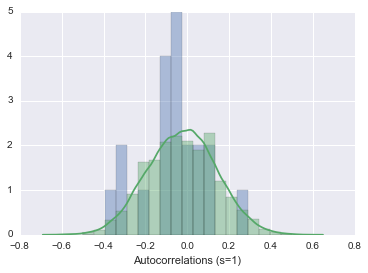

In [603]:
sns.distplot(match_acs, bins=np.linspace(-0.5,0.5,20), kde=False);
sns.distplot(random_acs, bins=np.linspace(-0.5,0.5,20))

### Building a model

In [624]:
Dataset['EPL 15/16'] = build_observations_dataset(Dataset['EPL 15/16 raw'], 'EPL 15/16')

In [606]:
# Build the dataset (inc. creating new features)
# Encode responses/features
# Remove outliers
# Impute for missing values
# EDA
# Dimensionality reduction
# Supervised learning

In [608]:
def null_content(series):
    return pd.isnull(series).sum()/len(series)

In [610]:
# Dataset['EPL 15/16'].apply(null_content) # No null values

In [626]:
le = preprocessing.LabelEncoder()
Dataset['EPL 15/16'].outcome = le.fit_transform(y=Dataset['EPL 15/16'].outcome)-1 # {A, D, H} -> {-1, 0, 1}

In [630]:
Dataset['EPL 15/16'].columns

Index(['away_conceded', 'away_conceded_away', 'away_conceded_home',
       'away_current_streak', 'away_draws', 'away_draws_away',
       'away_draws_home', 'away_goals', 'away_goals_away', 'away_goals_home',
       'away_home', 'away_losses', 'away_losses_away', 'away_losses_home',
       'away_max_win_streak', 'away_played', 'away_played_away',
       'away_played_home', 'away_total_corners', 'away_total_shots',
       'away_total_shots_on_target', 'away_wins', 'away_wins_away',
       'away_wins_home', 'home_conceded', 'home_conceded_away',
       'home_conceded_home', 'home_current_streak', 'home_draws',
       'home_draws_away', 'home_draws_home', 'home_goals', 'home_goals_away',
       'home_goals_home', 'home_home', 'home_losses', 'home_losses_away',
       'home_losses_home', 'home_max_win_streak', 'home_played',
       'home_played_away', 'home_played_home', 'home_total_corners',
       'home_total_shots', 'home_total_shots_on_target', 'home_wins',
       'home_wins_away', 'ho

In [661]:
feature_outcome_correlations = pd.DataFrame(np.corrcoef(Dataset['EPL 15/16'], rowvar=0),
                                            index=Dataset['EPL 15/16'].columns,
                                            columns=Dataset['EPL 15/16'].columns).outcome.sort_values()
feature_outcome_correlations.drop('outcome', inplace=True)
feature_outcome_correlations.dropna(inplace=True)

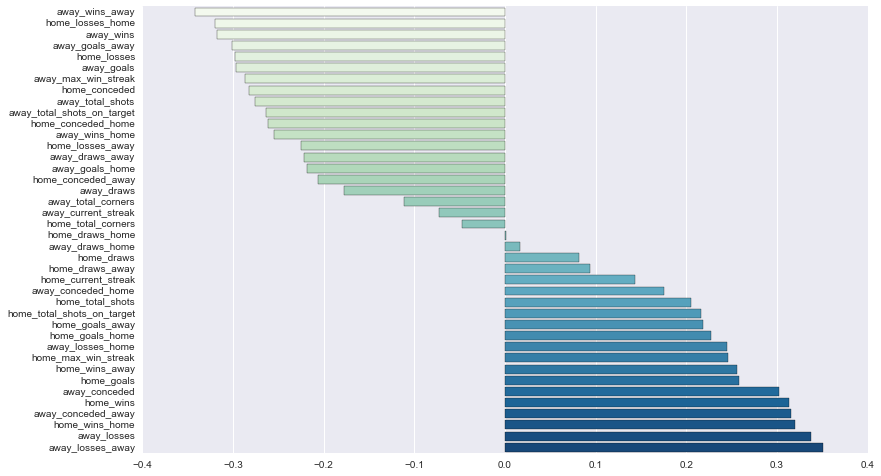

In [663]:
plt.figure(figsize=(13,8))
sns.barplot(x=feature_outcome_correlations.values, y=feature_outcome_correlations.index, palette='GnBu');

A negative correlation indicates that a feature is correlated with an away win, whereas a positive correlation indicates a feature is correlated with a home win.

In [664]:
feature_outcome_correlations.loc[feature_outcome_correlations>0]

home_draws_home               0.001232
away_draws_home               0.016395
home_draws                    0.081510
home_draws_away               0.093779
home_current_streak           0.143141
away_conceded_home            0.174915
home_total_shots              0.205054
home_total_shots_on_target    0.216654
home_goals_away               0.218200
home_goals_home               0.226830
away_losses_home              0.244739
home_max_win_streak           0.245361
home_wins_away                0.255895
home_goals                    0.257565
away_conceded                 0.302160
home_wins                     0.313282
away_conceded_away            0.315732
home_wins_home                0.320152
away_losses                   0.337592
away_losses_away              0.350146
Name: outcome, dtype: float64

In [665]:
feature_outcome_correlations.loc[feature_outcome_correlations < 0]
# For a home win:
# away losses away/total > home wins home/total ~ away conceded away > home goals ~ home wins away ~ max streak ...
# ...> home goals > home shots > away conceded at home > home current streak > home draws

# For an away win:
# away wins away/total > home losses home > away goals total/away ~ home losses ~ home conceded ~ away total shots ...
# ... ~ home conceded home ~ away wins at home > home losses away ~ away draws away ~ away goals at home ~ home conceded away ...
# ... > away draws > away corners > away current streak > home corners

away_wins_away               -0.341454
home_losses_home             -0.320215
away_wins                    -0.318023
away_goals_away              -0.301006
home_losses                  -0.297380
away_goals                   -0.296503
away_max_win_streak          -0.286776
home_conceded                -0.282788
away_total_shots             -0.275981
away_total_shots_on_target   -0.263252
home_conceded_home           -0.261615
away_wins_home               -0.254925
home_losses_away             -0.224553
away_draws_away              -0.221964
away_goals_home              -0.218913
home_conceded_away           -0.205751
away_draws                   -0.177907
away_total_corners           -0.111867
away_current_streak          -0.073020
home_total_corners           -0.047648
Name: outcome, dtype: float64

## To-dos

- Pull betting odds from websites
- Create new features
- Test out some models
- Build models against features
- Get player stats as features

In [900]:
Outcomes = {}
Outcomes['EPL 15/16'] = Dataset['EPL 15/16'].outcome

# Exploratory data analysis

### Dimensionality reduction

In [722]:
def df_fit_transform(tool, data, columns=None, index=None):
    if columns == None: columns = data.columns
    if index == None: index = data.index
    return pd.DataFrame(tool.fit_transform(data), columns=data.columns, index=data.index)

In [723]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale dataset
Dataset['EPL 15/16 scaled'] = df_fit_transform(StandardScaler(), Dataset['EPL 15/16'])

# Extract principal components
pca = PCA()
pca.fit(Dataset['EPL 15/16 scaled'])
pc_labels = ['PC_'+str(i) for i in range(0,len(Dataset['EPL 15/16 scaled'].columns))]
Dataset['EPL 15/16 PC'] = df_fit_transform(pca, Dataset['EPL 15/16 scaled'], columns=pc_labels)

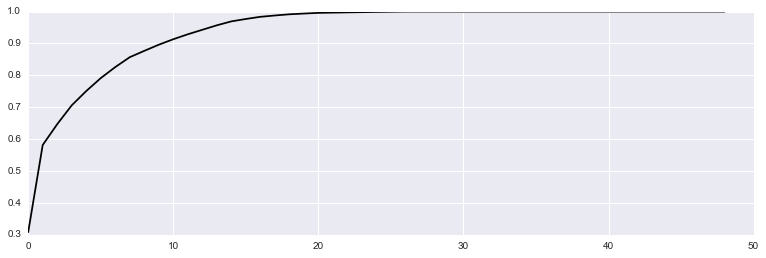

In [724]:
plt.figure(figsize=(13, 4))
plt.plot(pca.explained_variance_.cumsum()/(pca.explained_variance_.sum()), color='black')
plt.show()

In [736]:
def normalized_variance_threshold(data, exp_var_threshold=0.05):
    total_variance = VarianceThreshold().fit(data).variances_.sum()
    vt = VarianceThreshold(threshold=exp_var_threshold*total_variance)
    return pd.DataFrame(vt.fit_transform(data), index=data.index)

In [740]:
Dataset['EPL 15/16 VT'] = normalized_variance_threshold(Dataset['EPL 15/16 PC'])

In [741]:
Dataset['EPL 15/16 VT'].head(3)

,0,1,2,3
Bournemouth_vs_Aston Villa,-3.324670,-7.046422,-0.076309,-1.306271
Chelsea_vs_Swansea,-1.618800,-0.390607,-3.302916,-0.721301
Everton_vs_Watford,-1.467977,-0.886747,-3.092733,-0.778155


The probability of a team winning is a function of team's previous wins, goals scored, goals conceded, shots.
Is the probability function for a win dependent upon the number of matches played? e.g. Does the probability of the a team winning (as predicted from team information up to that date) depend on how many matches have been played so far in a season?
Probably not: we've seen that the autocorrelations tend to be smallish (i.e. the influence of the preceding match on the outcome of the present match is limited).

The uncertainty in an early-season prediction will be greater because there is less immediately relevant information available (ie. win/loss histories for that season). Is the preceding season a useful indicator?

What is the distribution of observations like in the direction of the principle components? This is important, as LDA assumes that feature values are normally distributed within a class.

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


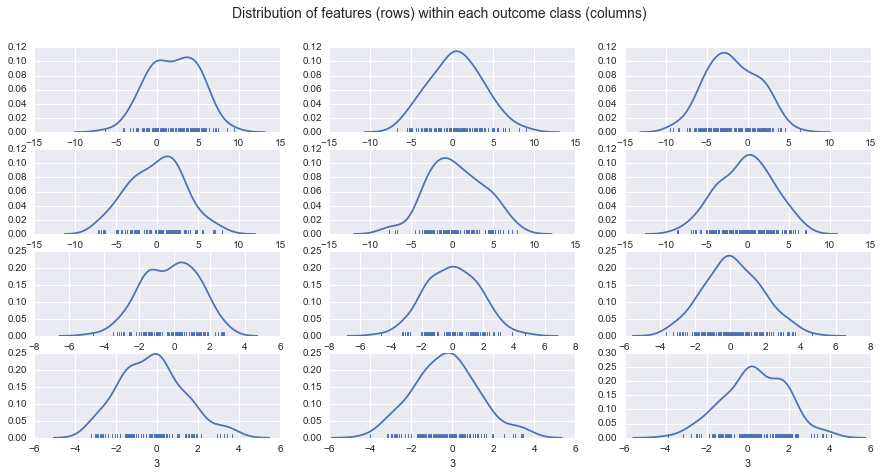

In [798]:
sp = plt.subplots(ncols=3, nrows=len(Dataset['EPL 15/16 VT'].columns), figsize=(15, 7))

for i in Dataset['EPL 15/16 VT'].columns.values:
    for j in [-1, 0, 1]:
        sns.distplot(Dataset['EPL 15/16 VT'].loc[(Outcomes['EPL 15/16']==j),i],
                     hist=False, kde=True, rug=True, ax=sp[1][i, j+1])
plt.suptitle('Distribution of features (rows) within each outcome class (columns)', size=14);

These plots suggest that the feature distributions are pretty much normal.

In [804]:
Dataset['EPL 15/16 VT'].columns = ['VT_'+str(j) for j in range(0, len(Dataset['EPL 15/16 VT'].columns))]

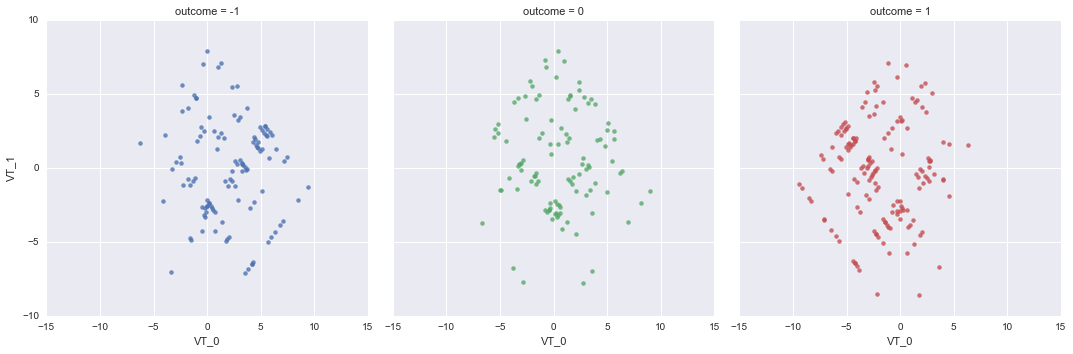

In [810]:
sns.lmplot(x='VT_0', y='VT_1', hue='outcome',
           data=Dataset['EPL 15/16 VT'].join(Outcomes['EPL 15/16']),
           fit_reg=False, col='outcome');

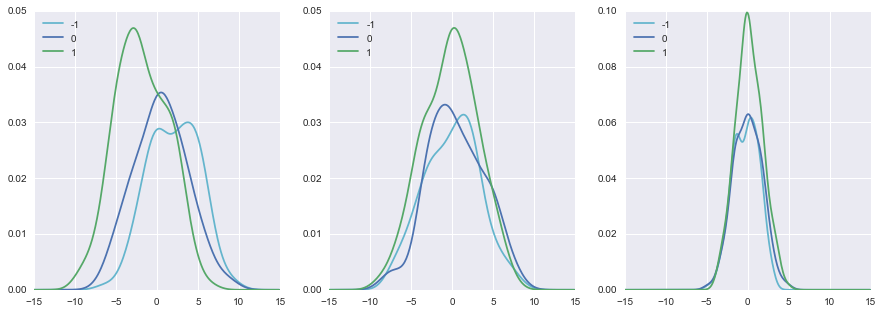

In [871]:
from scipy.stats import gaussian_kde

sp = plt.subplots(ncols=3, figsize=(15, 5))
priors = (Outcomes['EPL 15/16'].value_counts()/Outcomes['EPL 15/16'].value_counts().sum()).sort_values(ascending=True).values;
for i, col_label in enumerate(['VT_0', 'VT_1', 'VT_2']):
    for j in [-1, 0, 1]:
        density = gaussian_kde(Dataset['EPL 15/16 VT'].loc[Outcomes['EPL 15/16']==j, col_label])
        #density.covariance_factor = lambda: 0.3
        #density._compute_covariance()
        xs = np.arange(-15,15,.1)
        ys = density(xs)*priors[j+1]
        sp[1][i].plot(xs, ys, color=sns.color_palette('deep')[j], label=j);
    sp[1][i].legend(loc='upper left', shadow=True)

## Split data

In [879]:
Observations = {}
Responses = {}
(Observations['Training EPL 15/16'], Observations['Testing EPL 15/16'],
 Responses['Training EPL 15/16'], Responses['Testing EPL 15/16'] ) =  train_test_split(Dataset['EPL 15/16 VT'], Outcomes['EPL 15/16'])

### Dummy

In [893]:
from sklearn.dummy import DummyClassifier
Classifier = {}
Predictions = {}
Classifier['Dummy'] = DummyClassifier(random_state=0, strategy='stratified')
Classifier['Dummy'].fit(Observations['Training EPL 15/16'], Responses['Training EPL 15/16']);
Predictions['Dummy'] = cross_val_predict(Classifier['Dummy'], Observations['Training EPL 15/16'], Responses['Training EPL 15/16'])

### LDA

In [894]:
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_validation import train_test_split, cross_val_predict, cross_val_score

In [897]:
Classifier['LDA'] = LinearDiscriminantAnalysis()
Predictions['LDA'] = cross_val_predict(Classifier['LDA'], Observations['Training EPL 15/16'], Responses['Training EPL 15/16'])

### KNN

In [905]:
from sklearn.neighbors import KNeighborsClassifier

In [925]:
Classifier['KNN'] = KNeighborsClassifier(n_neighbors=7)
Predictions['KNN'] = cross_val_predict(Classifier['KNN'], Observations['Training EPL 15/16'], Responses['Training EPL 15/16'])

## Evaluate training performance of classifiers

#### Accuracy

In [898]:
metrics.accuracy_score(Responses['Training EPL 15/16'], Predictions['LDA'])

0.5368421052631579

In [899]:
metrics.accuracy_score(Responses['Training EPL 15/16'], Predictions['Dummy'])

0.34385964912280703

In [926]:
metrics.accuracy_score(Responses['Training EPL 15/16'], Predictions['KNN'])

0.512280701754386

In [ ]:
# Read in all data
# Extract features / format observations-outcomes
# Split into training and testing set
# Fit a model
# Use bootstrap to get model uncertainty
# Testing protocol:
    # Allocate models a fund
    # Have all models obey a betting criterion (e.g. Kelly)
    # f = (bp - q)/b
    # f = fraction of funds to bet
    # b = odds
    # Feed model test observations
    # If P_outcome_model-(2*SE on prediction) > Bookmaker_probability_of_outcome -> Place bet
    # Allocate winnings